### based on: https://hsf-training.github.io/analysis-essentials/advanced-python/45DemoReweighting.html
##### for more:  https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html , https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html

In [33]:
import numpy as np
import pandas as pd
from hep_ml import reweight
from matplotlib import pyplot as plt
import uproot

In [34]:
columns = ["nTracks","B_P", "Kst_892_0_PT", "B_Cone3_B_ptasy", "gamma_PT", "B_ETA" ]
path = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/"


with uproot.open(path +  "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as original_file:
        original_tree = original_file["DecayTree"]
        original = original_tree.arrays(columns, library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"} )
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as target_file:
        target_tree = target_file["DecayTree"]
        target = target_tree.arrays(columns + ["NB0_Kpigamma_sw"],library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"})

original_weights = np.ones(len(original))
target_weight = target["NB0_Kpigamma_sw"]



In [35]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))


In [23]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {"bins": 100, "density": True, "alpha": 0.7}


def draw_distributions(original, target, new_original_weights, sweight):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        print(column)
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(target[column],  weights=sweight, range=xlim, label="KpiG sWeights", **hist_settings)
        plt.hist(original[column], weights=new_original_weights, label="MC weighted", range=xlim, **hist_settings)
        plt.title(column)
        print("KS over ", column, " = ", ks_2samp_weighted(original[column], target[column],
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

nTracks
KS over  nTracks  =  0.2796173566166443
B_P
KS over  B_P  =  0.07591135211223132
Kst_892_0_PT
KS over  Kst_892_0_PT  =  0.22527525575931695
B_Cone3_B_ptasy
KS over  B_Cone3_B_ptasy  =  0.17912787265138447
gamma_PT
KS over  gamma_PT  =  0.15517087994430478
B_ETA
KS over  B_ETA  =  0.10504028172647356


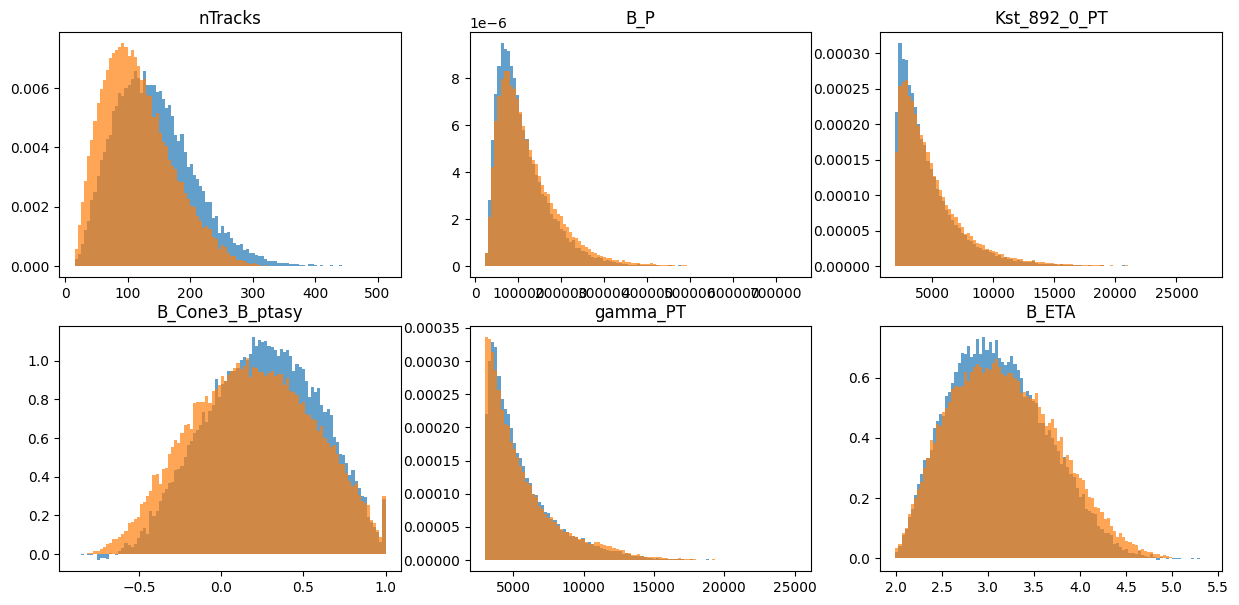

In [24]:
draw_distributions(original, target, original_weights, target["NB0_Kpigamma_sw"])

In [25]:
print(f"Original train shape: {original_train.shape}")
print(f"Target train shape: {target_train[columns].shape}")
print(f"Original weights train shape: {original_weights_train.shape}")
print(f"Original weights test shape: {original_weights_test.shape}")


Original train shape: (78656, 6)
Target train shape: (110877, 6)
Original weights train shape: (78656,)
Original weights test shape: (26219,)


In [26]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original_train, target_train[columns], original_weight = original_weights_train, target_weight= target_train["NB0_Kpigamma_sw"]  )

BinsReweighter(n_bins=20, n_neighs=1.0)

nTracks
KS over  nTracks  =  0.2813834606336937
B_P
KS over  B_P  =  0.06955919234446051
Kst_892_0_PT
KS over  Kst_892_0_PT  =  0.22322784977532378
B_Cone3_B_ptasy
KS over  B_Cone3_B_ptasy  =  0.18221707388571484
gamma_PT
KS over  gamma_PT  =  0.15440675734585652
B_ETA
KS over  B_ETA  =  0.11055364259691736


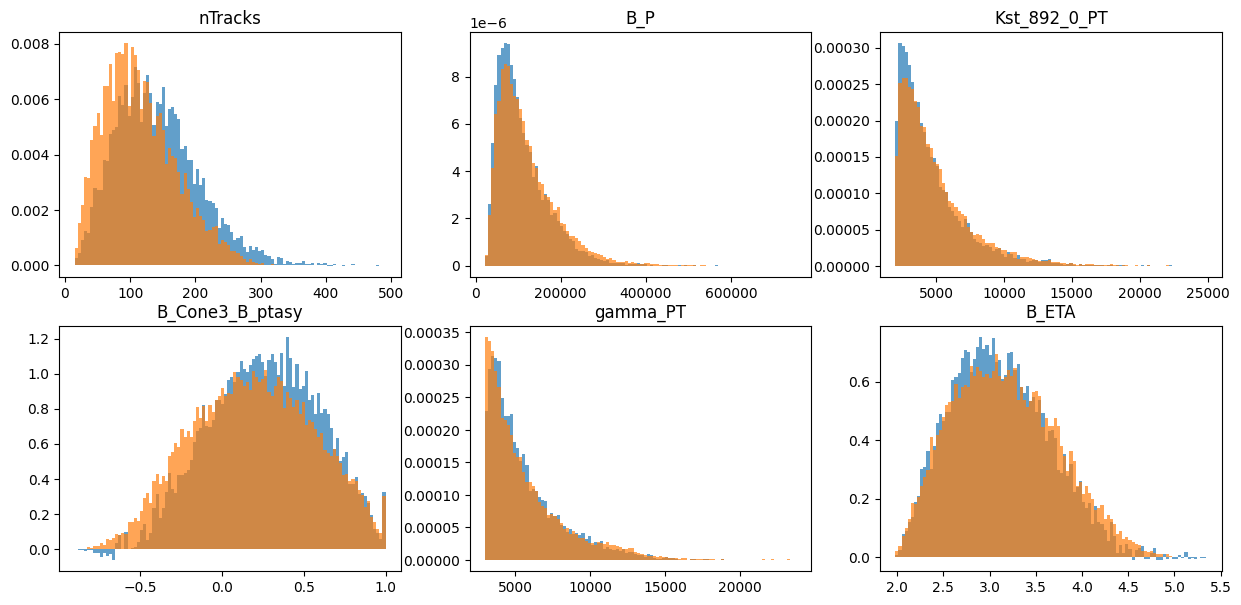

In [27]:
bins_weights_test = bins_reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, bins_weights_test, target_test["NB0_Kpigamma_sw"])

# GB-Reweighter

In [32]:
reweighter = reweight.GBReweighter(n_estimators=100, learning_rate=0.1, max_depth=2, min_samples_leaf=1000, gb_args={"subsample": 0.6})
reweighter.fit(original_train, target_train[columns], original_weight = original_weights_train, target_weight= target_train["NB0_Kpigamma_sw"]  )


GBReweighter(gb_args={'subsample': 0.6}, learning_rate=0.1, max_depth=2,
             min_samples_leaf=1000, n_estimators=100)

nTracks
KS over  nTracks  =  0.20003287602142583
B_P
KS over  B_P  =  0.07970756719685068
Kst_892_0_PT
KS over  Kst_892_0_PT  =  0.23949795489401005
B_Cone3_B_ptasy
KS over  B_Cone3_B_ptasy  =  0.19177590280474732
gamma_PT
KS over  gamma_PT  =  0.18054781617553534
B_ETA
KS over  B_ETA  =  0.12705527219317703


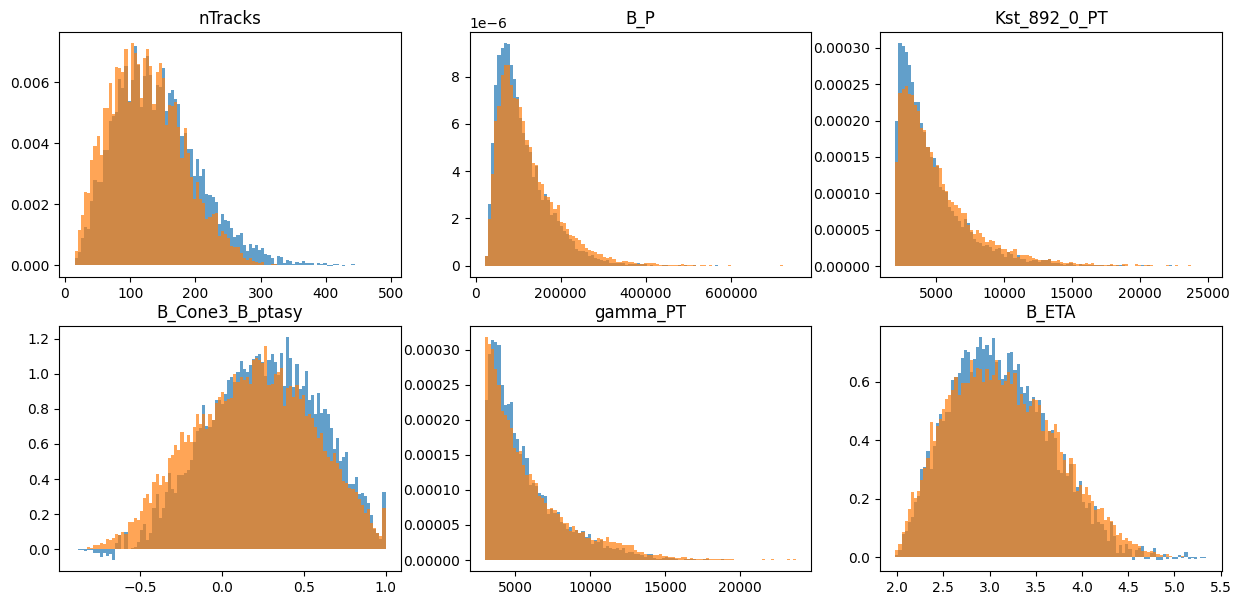

In [31]:
gb_weights_test = reweighter.predict_weights(original_test, original_weight = original_weights_test )
Norm = len(gb_weights_test)/sum(gb_weights_test)
mc_weights = [ Norm*el for el in gb_weights_test]
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test[columns], gb_weights_test, target_test["NB0_Kpigamma_sw"])

nTracks
KS over  nTracks  =  0.14377060970783317
B_P
KS over  B_P  =  0.05227631366635155
Kst_892_0_PT
KS over  Kst_892_0_PT  =  0.20956970270909597
B_Cone3_B_ptasy
KS over  B_Cone3_B_ptasy  =  0.23498508652521533
gamma_PT
KS over  gamma_PT  =  0.20283486247945315
B_ETA
KS over  B_ETA  =  0.16231339234599662


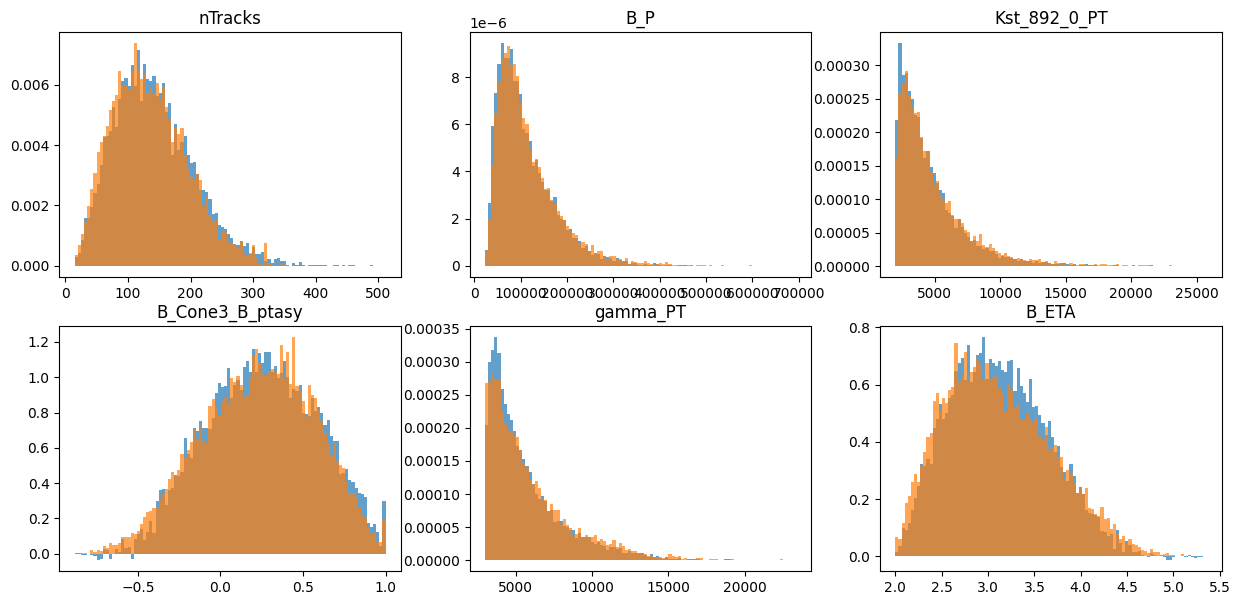

In [12]:
draw_distributions(original_test, target_test[columns], mc_weights, target_test["NB0_Kpigamma_sw"])

original 0.7617505170946556
bins 0.7607551318047074
gb_weights 0.7622242913045438


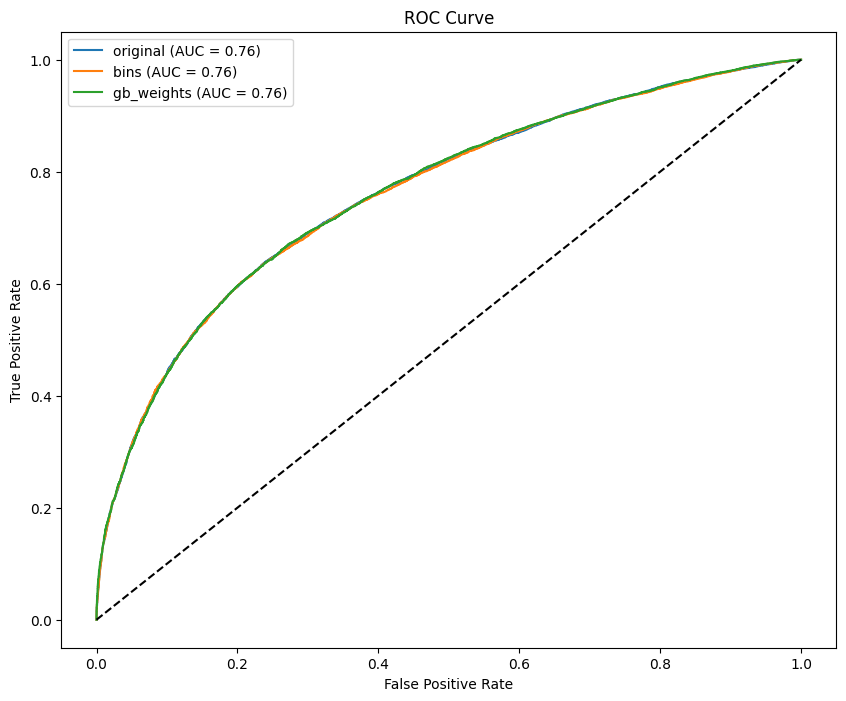

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

data = np.concatenate([original_test, target_test[columns]])
labels = np.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights["original"] = original_weights_test
weights["bins"] = bins_weights_test
weights["gb_weights"] = gb_weights_test

plt.figure(figsize=(10, 8))  # Added for plotting

for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))
    y_pred_proba = clf.predict_proba(Xts)[:, 1]
    auc_score = roc_auc_score(Yts, y_pred_proba, sample_weight=Wts)
    
    # Added calculation of fpr, tpr, and thresholds
    fpr, tpr, thresholds = roc_curve(Yts, y_pred_proba, sample_weight=Wts)
    
    # Added plotting of the ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")


plt.plot([0, 1], [0, 1], "k--")  # Added diagonal line for random classifier
plt.xlabel("False Positive Rate")  # Added x-axis label
plt.ylabel("True Positive Rate")  # Added y-axis label
plt.title("ROC Curve")  # Added title
plt.legend()  # Added legend
plt.show()  # Added show plot

# Folding reweighter

In [108]:
reweighter_base = reweight.GBReweighter(n_estimators=50,
                                        learning_rate=0.1, max_depth=3, min_samples_leaf=100,
                                        gb_args={"subsample": 0.6})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=4)
# it is not needed divide data into train/test parts; reweighter can be train on the whole samples
reweighter.fit(original, target[columns], original_weight = original_weights, target_weight= target["NB0_Kpigamma_sw"]  )

FoldingReweighter(base_reweighter=GBReweighter(gb_args={'subsample': 0.6},
                                               learning_rate=0.1,
                                               min_samples_leaf=100,
                                               n_estimators=50),
                  n_folds=4)

KFold prediction using folds column
nTracks
KS over  nTracks  =  0.14808493274217915
B_P
KS over  B_P  =  0.050699603966469886
Kst_892_0_PT
KS over  Kst_892_0_PT  =  0.20974411318102654
B_Cone3_B_ptasy
KS over  B_Cone3_B_ptasy  =  0.23365181293198345
gamma_PT
KS over  gamma_PT  =  0.19932924934167756
B_ETA
KS over  B_ETA  =  0.15142544181097095


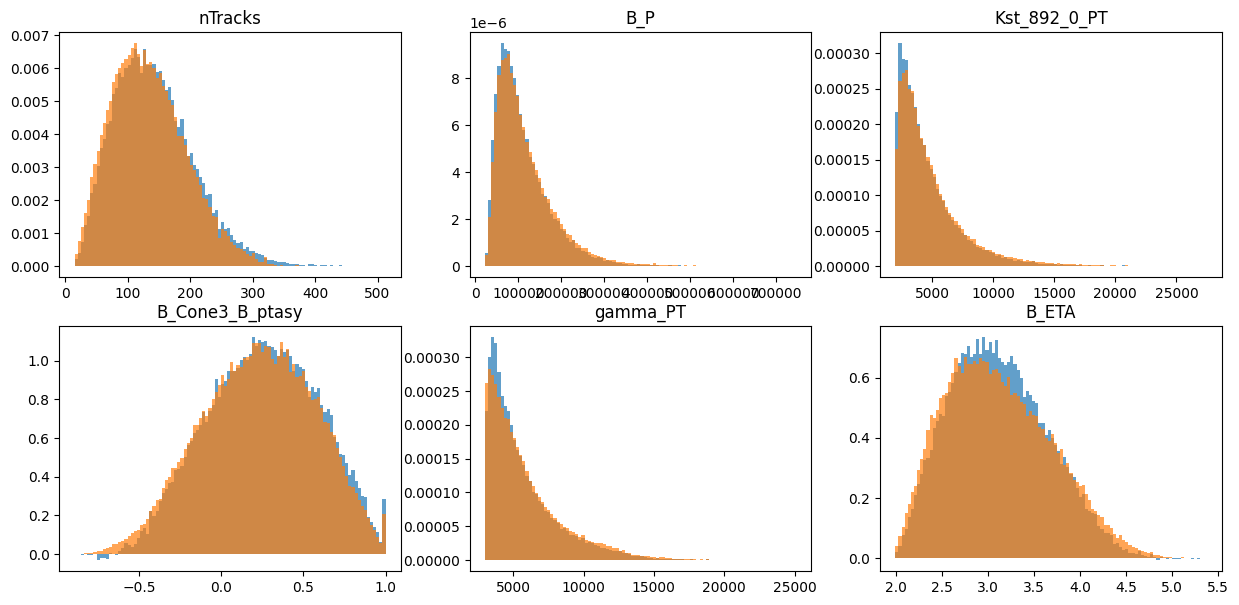

In [109]:
# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original, original_weight = original_weights )

draw_distributions(original, target, folding_weights, target["NB0_Kpigamma_sw"])

In [110]:
data = np.concatenate([original, target[columns]])
labels = np.array([0] * len(original) + [1] * len(target))

weights = {}
weights["original"] = original_weights
weights["2-folding"] = folding_weights


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.6, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.7533296459351797
2-folding 0.7052509200523995
